In [1]:
from pyscf import gto, dft, scf, lib, cc, fci
import numpy as np
import scipy as sp

Numpy 1.16 has memory leak bug  https://github.com/numpy/numpy/issues/13808
It is recommended to downgrade to numpy 1.15 or older


PAPER: J. Chem. Theory Comput. 2017, 13, 1503−1508

Steps:
1. Define systems (total, system_A, system_B)
2. Perform KS-DFT on FULL system: O--C--O
3. Find subsystem density matrices
4. Define embedded core Hamiltonian
5. Perform **DFT-in-DFT** calcualtion (use embedded core H)
6. Perform **WF-in-DFT** calcualtion (use embedded core H)
7. Use eq 12 in original paper to find overall energy!!!
8. Compare to true result

Fin.

**NOTE**: no iterative freeze and thaw DFT performed (aka assumed input structure is perfect structure)

# 1) Definitions

<IPython.core.display.Javascript object>


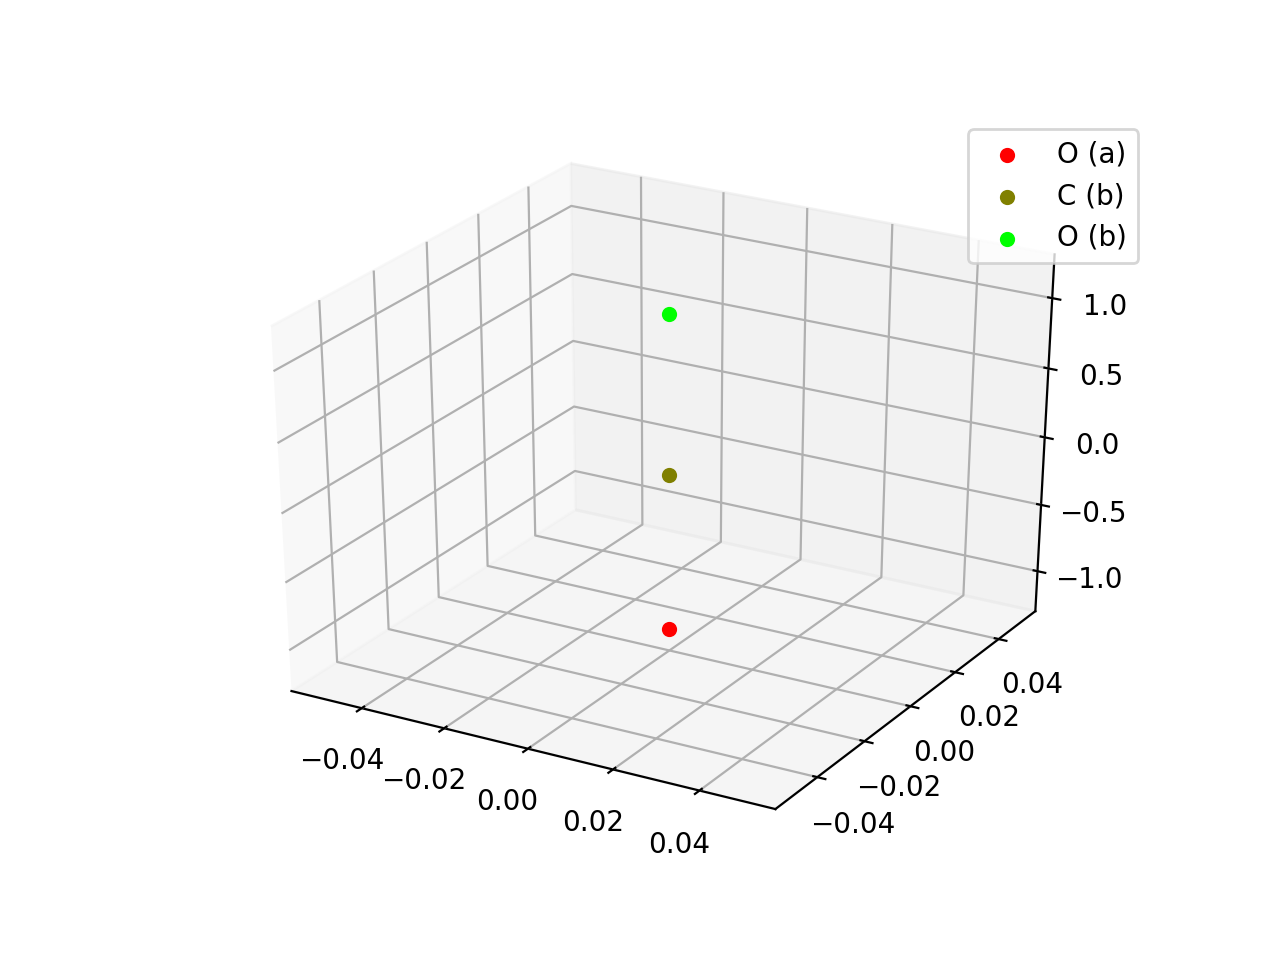

In [2]:
%matplotlib notebook
Bond_length=1.14
# Bond_length=0.01
O_a=(0, 0, -Bond_length)
C_b= (0, 0, 0)
O_b= (0,0,Bond_length)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*O_a, marker='o', color='red', label='O (a)')
ax.scatter(*C_b, marker='o', color='olive', label='C (b)')
ax.scatter(*O_b, marker='o', color='lime', label='O (b)')
plt.legend()
plt.show()


In [3]:
S_A = gto.Mole(atom='{} {} {} {}'.format('O',*O_a),
               basis="sto3g",
               charge=0,
               spin=0)
S_A.build()

In [4]:
S_B = gto.Mole(atom='{} {} {} {}'.format('C',*C_b) + "; " + '{} {} {} {}'.format('O',*O_b),
               basis="sto3g",
               charge=0,
               spin=0)
S_B.build()

In [5]:
S_T = gto.Mole(atom=S_A.atom + "; " +S_B.atom,
               basis="sto3g",
               charge=S_A.charge+S_B.charge,
               spin=S_A.spin+S_B.spin)

S_T.build()
print(S_T.atom)

O 0 0 -1.14; C 0 0 0; O 0 0 1.14


# 2. Full DFT calculation

In [6]:
S_Tscf = scf.RKS(S_T)
S_Tscf.xc = 'lda,vwn'
S_Tscf.small_rho_cutoff = 1e-20
S_Tscf.kernel()

converged SCF energy = -184.549802955807


/Users/lex/anaconda3/envs/pyscf/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:


-184.54980295580702

# 3. Get subsystem density matrices!

In [7]:
# find number of orbitals in each system
na = S_A.nao_nr()
nb = S_B.nao_nr()
nt = S_T.nao_nr()

In [8]:
dm_T = S_Tscf.make_rdm1()
C_occupied = S_Tscf.mo_coeff[:, S_Tscf.mo_occ>0]
full_denisty = 2*np.dot(C_occupied, C_occupied.conj().T) # gamma_Total
print(np.allclose(full_denisty, dm_T))

J_Tot, K_Tot = S_Tscf.get_jk(dm=dm_T) # Coulomb (J) and exchange (K)
Fock_T = S_Tscf.get_hcore() + J_Tot + K_Tot

True


In [9]:
C_occupied_A =  C_occupied[:, :na]
dm_A = 2*np.dot(C_occupied_A, C_occupied_A.conj().T) # gamma_A

In [10]:
C_occupied_B =  C_occupied[:, na:]
dm_B = 2*np.dot(C_occupied_B, C_occupied_B.conj().T) # gamma_B

print('gamma_A + gamma_B = gamma_T:', np.allclose(dm_A+dm_B, dm_T)) # check y_A + y_B = y_T

gamma_A + gamma_B = gamma_T: True


**NOTE:**
- I have simply sliced the occupied orbitals according to no. of orbitals in A and B
- This will work correctly according to linear algebra
- BUT not sure if we are correctly selecting the right part of the molecule
    - please look into this further

# 4. define embedded core H

In [11]:
#### Mu projector method!!!! 
# equation (5) of Goodpaster paper
# comment box below out to use!

# ao_overlap = S_Tscf.get_ovlp()
# projector = ao_overlap.dot(dm_B).dot(ao_overlap)

# print(np.trace(projector.dot(dm_A)))
# print(np.trace(projector.dot(dm_B)))

In [12]:
## Define the Huzinga operator 
# equation (6) of Goodpaster paper

ao_overlap = S_Tscf.get_ovlp()

F_yb_S = np.dot(Fock_T, dm_B.dot(ao_overlap))
S_yb_F = F_yb_S.T

projector = -0.5*(F_yb_S+S_yb_F) # Huzinga operator

print(np.trace(projector.dot(dm_A)))
print(np.trace(projector.dot(dm_B)))

8.326672684688674e-17
-57.95569629097332


In [13]:
# Get subsystem energy terms and potential matrices
# active part (system A)

j_act=S_Tscf.get_j(dm=dm_A)
k_act= S_Tscf.get_k(dm=dm_A)
two_e_term_act=S_Tscf.get_veff(dm=dm_A)
e_xc_act= two_e_term_act.exc
v_xc_act= two_e_term_act-j_act-k_act

# Hadamard product
# https://stackoverflow.com/questions/26089893/understanding-numpys-einsum 
e_active = np.einsum('ij,ij', dm_A, j_act/2) + e_xc_act
e_active

36.608824826072045

In [14]:
# # environment part (system B)

# j_environ= S_Tscf.get_j(dm=dm_B)
# k_environ= S_Tscf.get_k(dm=dm_B)
# two_e_term_environ=S_Tscf.get_veff(dm=dm_B)
# e_xc_environ=two_e_term_environ.exc
# v_xc_environ=two_e_term_environ-j_environ-k_environ

# e_environ= np.einsum('ij,ij', dm_B, j_environ/2) + e_xc_environ
# e_environ

In [15]:
# V_xc_total = S_Tscf.get_veff() # g(gamma_A + gamma_B)
# E_xc_total = S_Tscf.get_veff().exc
# v_emb = j_environ + V_xc_total - v_xc_act + projector 

In [16]:
V_xc_total = S_Tscf.get_veff() # g(gamma_A + gamma_B)
E_xc_total = S_Tscf.get_veff().exc


# equation (3) Goodpastor  [note excludes Hcore]
v_emb = V_xc_total - v_xc_act + projector # g(gamma_A + gamma_B) - g(gamma_A) + Pb

# 5. perform DFT_in_DFT calculation

In [1]:
h_core = S_Tscf.get_hcore()

# h_core_embed = h_core + embedding_potential + projector
S_Tscf_embedded = scf.RKS(S_T) # <---different level of theory!!
S_Tscf.xc = 'lda,vwn'
# S_Tscf.xc = 'b3lyp'
S_Tscf_embedded.h_core = lambda *args: v_emb + h_core
S_Tscf_embedded.conv_tol= 1e-10
S_Tscf_embedded.kernel()

print('')
print('standard KS calc: E=', S_Tscf.e_tot)
print('embedded DFT calc: E=',S_Tscf_embedded.e_tot)

NameError: name 'S_Tscf' is not defined

# 6. NEXT do WF calc on subsystem A

In [18]:
HF_Sa_embedded = scf.RHF(S_T) 
HF_Sa_embedded.run()
E_HF_no_embedding = HF_Sa_embedded.e_tot

HF_Sa_embedded.h_core = lambda *args: v_emb + h_core # <--- h_core_embed
HF_Sa_embedded.conv_tol= 1e-6
HF_Sa_embedded.kernel()

E_HF_with_embedding = HF_Sa_embedded.e_tot

print('')
print('')
print('Energy with standard Hamiltonian = ', E_HF_no_embedding)
print('Energy with embedded Hamiltonian = ',E_HF_with_embedding)

converged SCF energy = -185.057009982185
converged SCF energy = -185.057009982169


Energy with standard Hamiltonian =  -185.05700998218532
Energy with embedded Hamiltonian =  -185.05700998216867


<class 'pyscf.scf.hf.RHF'> does not have attributes  h_core


In [19]:
# coupled cluster
Sa_CC = cc.CCSD(HF_Sa_embedded)
ecc, t1, t2 = Sa_CC.kernel()
Energy_CC_Sa = Sa_CC.e_tot + ecc

E(CCSD) = -185.2427064000316  E_corr = -0.1856964178629046


/Users/lex/anaconda3/envs/pyscf/lib/python3.7/site-packages/pyscf/lib/misc.py:874: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


# 7. WF in DFT energy


$$E_{total} = E_{DFT}^{Total} - E_{DFT-in-DFT}^{A} + E_{WF-in-DFT}^{A} $$

- $E_{DFT}^{Total}$ is the full system Kohn-Sham DFT energy
- $E_{DFT-in-DFT}^{A}$ is the DFT energy of subsystem A embedded in the DFT potential of the rest of the system
- $E_{WF-in-DFT}^{A}$ is the CCSD energy of subsystem A embedded in the DFT potential of the rest of the system

In [20]:
E_WF_in_DFT = S_Tscf.e_tot - S_Tscf_embedded.e_tot + Energy_CC_Sa
E_WF_in_DFT

-185.42840281860595

# 8. Compare to FCI Energy

In [21]:
# Perform a FCI to check the validity of results
cisolver = fci.FCI(S_T, S_Tscf.mo_coeff)
efci = cisolver.kernel()[0]
print("FCI energy:", efci)

FCI energy: -185.2613976728537


In [22]:
print('WF_in_DFT ΔE = ', np.abs(efci-E_WF_in_DFT))
print("Relative error for WF_in_DFT:", np.abs(E_WF_in_DFT-efci)/efci)

WF_in_DFT ΔE =  0.1670051457522561
Relative error for WF_in_DFT: -0.00090145679483194


In [23]:
print('KS_total ΔE = ', np.abs(efci-S_Tscf.e_tot))

print("Relative error for KSDFT:", np.abs(S_Tscf.e_tot-efci)/efci)

KS_total ΔE =  0.7115947170466654
Relative error for KSDFT: -0.0038410307057234042


In [24]:
if np.abs(efci-E_WF_in_DFT)<np.abs(efci-S_Tscf.e_tot):
    print('Our method is performing better!')
else:
    print('Our method is performing worse')

Our method is performing better!
